In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 24b

##  Convolutional Neural Network (CNN)
<img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify Flowers dataset.

In [2]:
###-----------------
### Import Libraries
###-----------------

import os

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

%matplotlib inline

In [3]:
###------------------
### Memory Management
###------------------

physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-12-17 05:50:22.676993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 05:50:22.772547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 05:50:22.773393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
###---------------------------------------
### Global  parameters and Hyperparamaters
###---------------------------------------

inpDir = '/kaggle/input/flower-photos' # location where input data is stored
outDir = '/kaggle/working/output' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = '/kaggle/working/' # location to save model files
valDir = 'valid_flowers' # location related to this dataset
altName = 'dropout_bn_no_bias_leaky_flowers' # Model file name for this alternative
checkpoint_dir = '/kaggle/working/'
checkpoint_filepath = '/kaggle/working/weight.h5'
checkpoint_prefix = 'final_weights'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 100   # number of cycles to run

ALPHA = 0.01

BATCH_SIZE = 16

TEST_SIZE = 0.2

IMG_HEIGHT = 190

IMG_WIDTH = 190

FLIP_MODE = "horizontal_and_vertical"

# for rotation transformation 
ROTATION_FACTOR = (-0.1, 0.1) 

FILL_MODE = 'nearest'

ES_PATIENCE = 20 # if performance does not improve stop

LR_PATIENCE = 5 # if performace is not improving reduce alpha

LR_FACTOR = 0.9 # rate of reduction of alpha



# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,6),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [5]:
def fn_plot_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    # create figure and axis array
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    # take first axis
    ax = axes[0]

    # Plot Column 0 and 2 (Loss and validation loss)
    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    # get minimum values for plotting
    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords
    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # label the axes
    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    # grids make it look good
    ax.grid()
    
    # take second axis object
    ax = axes[1]

    # plot column 1 and 3 (accuracy and validation accuracy)
    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords
    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # label the axes
    ax.set_xlabel("Epochs")
    
    ax.set_ylabel(hist_df.columns[1].capitalize())
    
    # grids make it look good
    ax.grid()
    
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
    # display all open images
    plt.show()

In [6]:
# Function to plot number of classes in training and testing sets
def fn_plot_label(tr_ds, ts_ds):
    
    '''
        Args:
            tr_ds :  Training Dataset
            ts_ds : Testing dataset
        Returns : none
    '''

    # create figure
    plt.figure(figsize = (15,5))
    
    # create two subplots
    plt.subplot(1,2,1)

    # create array of training labels
    train_labels = tf.concat([y for x, y in tr_ds], axis = 0).numpy()
    
    # get unique labels and counts thereof
    unique, _, counts = tf.unique_with_counts(train_labels)
    
    # bar plot
    plt.bar(range(len(unique)), counts, align='center',color = 'DarkBlue', alpha = 0.7)
    
    # add title
    plt.title('Training Set')
    
    # add ticks on axis
    plt.xticks(range(len(unique)), class_names)
    
    # grids make it look good
    plt.grid()


    #pick second image
    plt.subplot(1,2,2)

    # create array of testing labels 
    val_labels = tf.concat([y for x, y in ts_ds], axis = 0).numpy()
    
    # get unique labels and counts thereof
    unique, _, counts = tf.unique_with_counts(val_labels)
    
    # bar plot
    plt.bar(range(len(unique)), counts, align='center', color = 'Orange', alpha = 0.7)
    
    # add title
    plt.title('Test Set')
    
    # add ticks
    plt.xticks(range(len(unique)), class_names)
    
    # grids make it look good
    plt.grid()
    
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
    # display all open figures
    plt.show()

## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [7]:
'''
    For reading from web link
'''

#import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                   fname='flower_photos',
#                                   untar=True)
#data_dir = pathlib.Path(data_dir)
'''
    For reading from local directory
'''
data_dir = os.path.join(inpDir, subDir)

In [8]:
data_dir

'/kaggle/input/flower-photos/flower_photos'

In [9]:
# list content of data_dir
os.listdir(data_dir)

['LICENSE.txt', 'dandelion', 'sunflowers', 'daisy', 'roses', 'tulips']

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='training',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


2022-12-17 05:50:24.181129: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 05:50:24.181574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 05:50:24.182481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 05:50:24.183127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

### Is it picking the class names?

In [11]:
class_names = train_ds.class_names
print('total ', len(class_names), class_names)

total  5 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Verify the data

To verify that the dataset looks correct, let's plot the first batch from the training set and display the class name below each image.


2022-12-17 05:50:26.821498: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


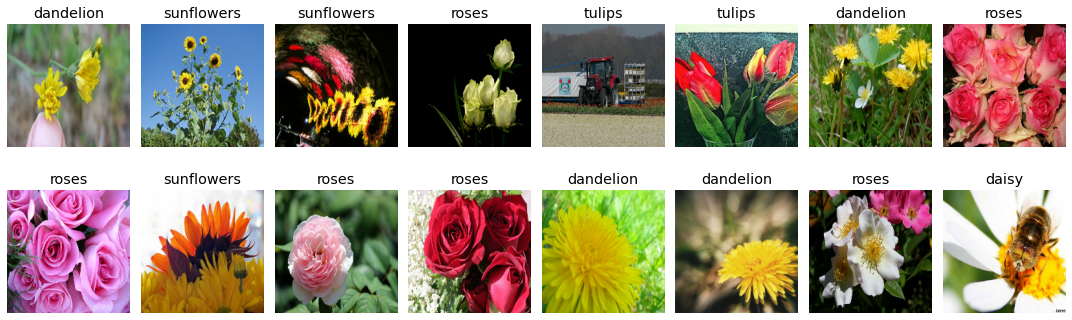

In [12]:
# set figure size
plt.figure(figsize=(15,5))

# take one batch of the dataset
for images, labels in train_ds.take(1):
    
    # iterate through the batch
    for i in range(BATCH_SIZE):
        
        # add a subplot
        plt.subplot(int(BATCH_SIZE/8), 8, i+1 )
        
        # switch off the grids
        plt.grid(False)
        
        # image_size may have converted these images to float
        plt.imshow(images[i].numpy().astype("uint8")) 
        
        # display class in the title
        plt.title(class_names[labels[i]])
        
        # no axis
        plt.axis("off")
        
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
# display all open images    
plt.show()

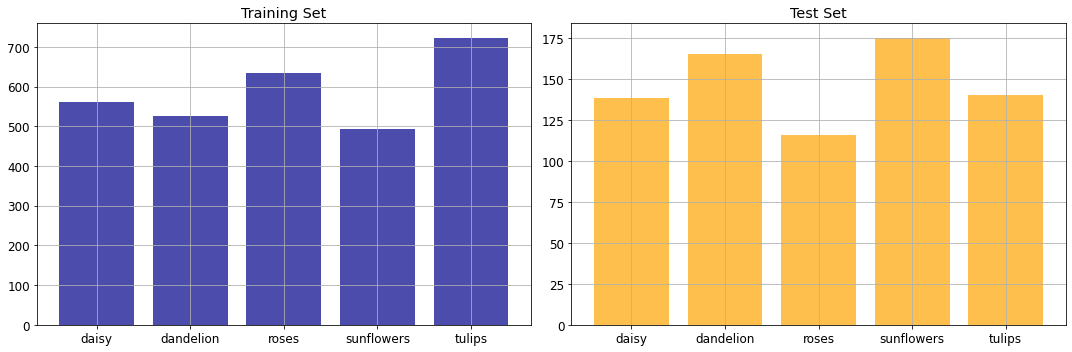

In [13]:
# how many examples in each of the class
fn_plot_label(train_ds, test_ds)

In [14]:
# pick the input_shape 

input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
num_classes = len(train_ds.class_names)

## RandomZoom

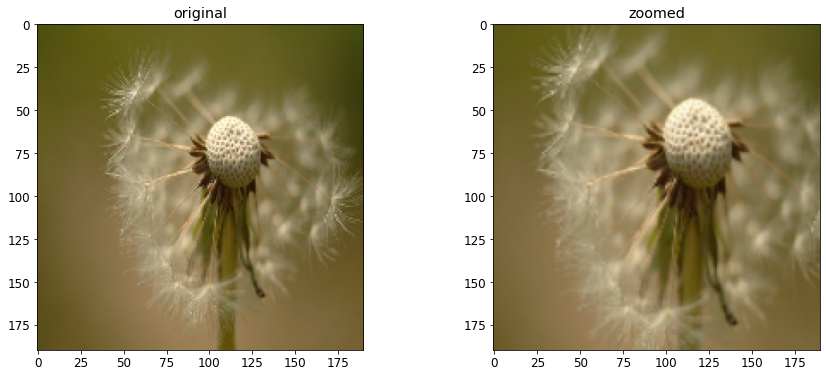

In [15]:
layer = tf.keras.layers.RandomZoom(height_factor=(-0.2,-0.2),
                                   width_factor=(-0.2,-0.2)
                                  )

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):
    
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    
    plt.title('zoomed')
    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))
 

### Random Rotation

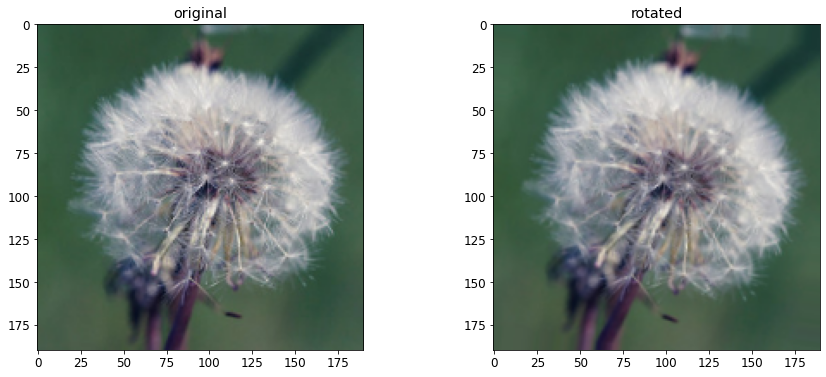

In [16]:
layer = tf.keras.layers.RandomRotation((-0.5, 0.5),
                                       fill_mode='nearest')

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):
    
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    
    plt.title('rotated')
    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

### Standardize the data

The original RGB channel values are in the [0, 255] range. `Resizing` has converted those values into **floats**. Standardize values to be in the [0, 1] range by using the `tf.keras.layers.experimental.preprocessing.Rescaling` layer.

In [17]:
## Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
def build_model(input_shape, n_classes):
    
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Rescaling(1./255.))
    
    
    # data augumentation layers
    model.add(tf.keras.layers.RandomRotation(ROTATION_FACTOR, 
                                             fill_mode= FILL_MODE,
                                             seed= RANDOM_STATE
                                            ))
    
    model.add(tf.keras.layers.RandomFlip(mode=FLIP_MODE, seed= RANDOM_STATE))
    
    
    model.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=input_shape)) #188X188
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    #dropout after first convolution
    tf.keras.layers.Dropout(0.15)
    model.add(tf.keras.layers.MaxPooling2D((2, 2))) #94X94
   
        
    model.add(tf.keras.layers.Conv2D(64, (3, 3))) #92X92
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    #dropout after second convolution
    tf.keras.layers.Dropout(0.15)
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))  #46X46
              

    model.add(tf.keras.layers.Conv2D(128, (3, 3)))#44X44
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    #dropout after third convolution
    tf.keras.layers.Dropout(0.15)
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))  #22X22
              

    model.add(tf.keras.layers.Conv2D(256, (3, 3))) #20X20
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    #dropout after fourth convolution
    tf.keras.layers.Dropout(0.15)
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))  #10X10
              

    model.add(tf.keras.layers.Conv2D(512, (3, 3)))#8X8
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    #dropout after fourth convolution
    tf.keras.layers.Dropout(0.15)          
    
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))  #4X4

    model.add(tf.keras.layers.Conv2D(1024, (3, 3))) #2*2
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    #dropout after fifth convolution
    tf.keras.layers.Dropout(0.15)


    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    
    
    tf.keras.layers.Dropout(0.15)

    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    
    tf.keras.layers.Dropout(0.15)

    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    
    tf.keras.layers.Dropout(0.15)

    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dense(n_classes))
    
    return model

In [19]:
# Early Stopping
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  restore_best_weights=True,
                                                  patience=ES_PATIENCE,
                                                  verbose=1)


# Save weights
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                    monitor='val_loss',
                                                    mode='auto',
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    verbose=1)


# learning rate schedule
# Reduction schedule for alpha
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=LR_FACTOR,
                                                 patience=LR_PATIENCE)

# loss Function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True)

In [20]:
model = build_model(input_shape,num_classes)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy']
         )

In [21]:

history = model.fit(train_ds, 
                    validation_data=test_ds,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                   callbacks= [early_callback, model_callback, lr_reduce])

Epoch 1/100


2022-12-17 05:50:44.665866: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


184/184 [==============================] - 18s 48ms/step - loss: 1.2173 - accuracy: 0.5089 - val_loss: 3.2349 - val_accuracy: 0.2384

Epoch 00001: val_loss improved from inf to 3.23491, saving model to /kaggle/working/weight.h5
Epoch 2/100
184/184 [==============================] - 5s 26ms/step - loss: 1.0581 - accuracy: 0.5702 - val_loss: 1.7146 - val_accuracy: 0.4850

Epoch 00002: val_loss improved from 3.23491 to 1.71465, saving model to /kaggle/working/weight.h5
Epoch 3/100
184/184 [==============================] - 5s 26ms/step - loss: 0.9652 - accuracy: 0.6093 - val_loss: 2.0009 - val_accuracy: 0.4373

Epoch 00003: val_loss did not improve from 1.71465
Epoch 4/100
184/184 [==============================] - 5s 26ms/step - loss: 0.9287 - accuracy: 0.6386 - val_loss: 1.2443 - val_accuracy: 0.5450

Epoch 00004: val_loss improved from 1.71465 to 1.24434, saving model to /kaggle/working/weight.h5
Epoch 5/100
184/184 [==============================] - 5s 26ms/step - loss: 0.8910 - accur

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 190, 190, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 190, 190, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 190, 190, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 188, 188, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 188, 188, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 188, 188, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 94, 94, 32)        0

In [23]:
model.evaluate (test_ds, verbose=2)

46/46 - 0s - loss: 0.7791 - accuracy: 0.7629


[0.7791188955307007, 0.7629427909851074]

        loss  accuracy  val_loss  val_accuracy       lr
55  0.091011  0.968324  0.954854      0.773842  0.00059
56  0.073487  0.975817  0.978855      0.771117  0.00059
57  0.067228  0.977180  0.975646      0.777929  0.00059
58  0.058600  0.978542  1.284902      0.745232  0.00059
59  0.076448  0.973093  1.059652      0.783379  0.00059


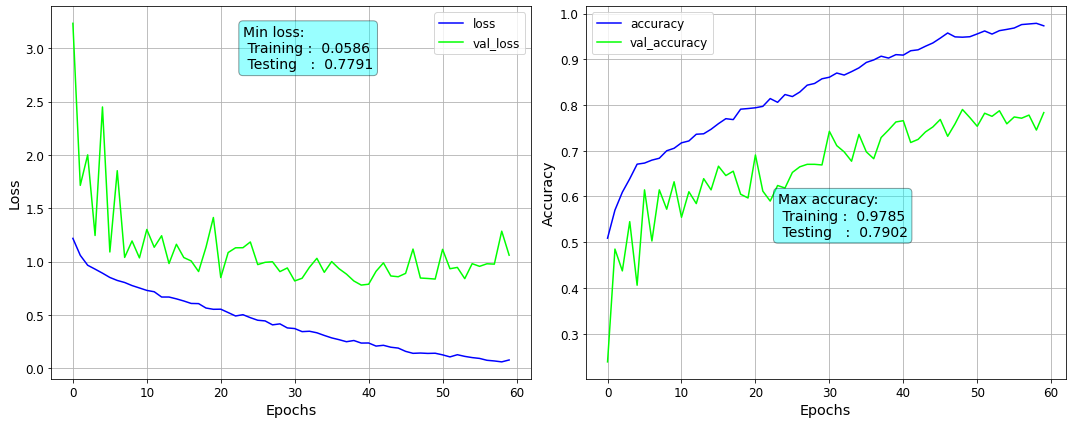

In [24]:
res_df = pd.DataFrame(history.history)
print(res_df.tail())
fn_plot_hist(res_df)

### Reload best Weights for evaluation

In [25]:
del model

In [26]:
tf.train.latest_checkpoint(checkpoint_dir)

In [27]:
checkpoint_dir

'/kaggle/working/'

In [28]:
os.listdir(checkpoint_dir)


['weight.h5', '__notebook_source__.ipynb', '.virtual_documents']

In [29]:
model1 = build_model(input_shape, num_classes)

model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model1.evaluate(test_ds, verbose=2)

model1.load_weights(checkpoint_filepath)


46/46 - 1s - loss: 1.6095 - accuracy: 0.2003


### Evaluate the model

In [30]:
#yhat = model.predict(X_test, batch_size=n_batch)
yhat = model1.predict(test_ds)

In [31]:
y_test = tf.concat([y for x, y in test_ds], axis=0)

In [32]:
y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data : {:.3f}%'.format( accuracy_score(y_test, y_pred)*100))

Accuracy score on Test Data : 76.294%


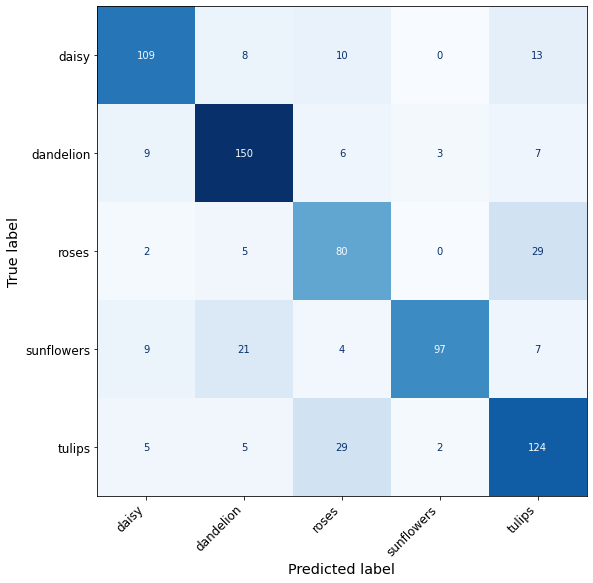

In [33]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_names)

fig, ax = plt.subplots(figsize = (9,9))

disp.plot(ax = ax, cmap=plt.cm.Blues, colorbar=False);

ax.set_xticklabels(class_names,rotation=45, ha='right');

## for images, labels in test_ds.take( 5 ):
    
    # Predict again to keep y_pred in synch with the images
    yhat = model1.predict(images, verbose = 0)
    
    y_pred = yhat.argmax(axis = 1)
    
    for i in range ( BATCH_SIZE ):
        
        plt.subplot(int( BATCH_SIZE / 8 ), 8, i+1 )
        
        plt.grid(False)
        
        plt.imshow ( images[i].numpy().astype( "uint8" ) )
        
        plt.title('{} \n {}'.format( class_names[labels.numpy()[i]], class_names[y_pred[i]]))
        
        plt.axis("off")
        
    plt.tight_layout()
    
    plt.show()

In [35]:
test_loss, test_acc = model1.evaluate(test_ds, verbose=1)

46/46 [==============================] - 0s 9ms/step - loss: 0.7791 - accuracy: 0.7629


### Save complete model for future use

In [36]:
model_path = checkpoint_prefix +'.h5'
model1.save(model_path, save_format='h5')

### Verify if everything was saved ok

In [37]:
new_model = tf.keras.models.load_model(model_path)

In [38]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 190, 190, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 190, 190, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 190, 190, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 188, 188, 32)      896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 188, 188, 32)      128       
_________________________________________________________________
activation_10 (Activation)   (None, 188, 188, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 94, 94, 32)       

In [39]:
yhat = new_model.predict(test_ds)

y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data : {:.3f}%'.format( accuracy_score(y_test, y_pred)*100))

Accuracy score on Test Data : 76.294%
